In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
from matplotlib.cm import jet
%matplotlib inline

import copy

In [3]:
from background import SeqNMFBackground
from clusters import SeqNMFCluster, SeqNMFClusterFactory
from models import DirichletProcessMixtureModel, NeymanScottModel
from util import permute_to_match, onehot, compute_state_overlap

In [4]:
npr.seed(0)

In [5]:
# Make a Neyman-Scott model with gaussian marks
T = 500          # time window
N = 20            # number of neurons
M = 4             # number of motif types

lmbda0 = 200     # expected number of background events (across all nodes)
mu = 100          # expected number of latent events
alpha = 10         # shape of gamma prior on latent event weights
beta = 10/(N//M)   # rate of gamma prior on latent event weights

In [6]:
bkgd_class = SeqNMFBackground
bkgd_hypers = dict(
    T=T,
    num_neurons=N,
    pi_bkgd=npr.dirichlet(np.ones(N))
    )
 
# Make "cascade" motifs
pis = 1e-4 * np.ones((M, N))
deltas = np.zeros((M, N))
sigmasqs = 0.1 * np.ones((M, N))
for m in range(M):
    n_start = m * N // M
    n_stop = (m + 1) * N // M
    pis[m, n_start:n_stop] = 1 / (n_stop - n_start)
    deltas[m, n_start:n_stop] = np.arange(n_stop - n_start)

pis /= pis.sum(axis=1, keepdims=True)

clus_factory_hypers = dict(
    T=T,
    num_motif_types=M,
    num_neurons=N,
    eta_conc=10.0,
    pi_conc=0.1,
    delta_mean=0.0,
    delta_nu=0.1,
    sigmasq_a=1.0,
    sigmasq_b=0.1,
)

test_clus_factory_hypers = copy.deepcopy(clus_factory_hypers)
test_clus_factory_hypers['num_motif_types'] = M

# Make a cluster factory with particular hyperparameters
clus_factory = SeqNMFClusterFactory(**clus_factory_hypers)
clus_factory.eta = np.ones(M) / M
clus_factory.pis = pis
clus_factory.deltas = deltas
clus_factory.sigmasqs = sigmasqs

In [7]:
bkgd_class(**bkgd_hypers)

# Make a true model and sample from it

In [8]:
true_model = NeymanScottModel(mu, alpha, beta, lmbda0, bkgd_class(**bkgd_hypers), clus_factory)

# Sample from the model
sample_kwargs = dict(time_kwargs=dict(), mark_kwargs=dict())
data, parents, clusters, weights = true_model.generate(**sample_kwargs)
nodes, times = data[:, 0], data[:, 1]

# Only keep the valid times
# valid = times < T
valid = np.ones_like(times, dtype=bool)
nodes = nodes[valid]
times = times[valid]
parents = parents[valid]

# Sort the data by time
perm = np.argsort(times)
nodes = nodes[perm]
times = times[perm]
parents = parents[perm]
data = np.column_stack((nodes, times))

In [9]:
cluster_prms = [cluster.sample_posterior() for cluster in clusters]
cluster_types, cluster_times = list(zip(*cluster_prms))

In [10]:
print("num latent events ", len(clusters))
print("num observed events ", len(data))

num latent events  90
num observed events  680


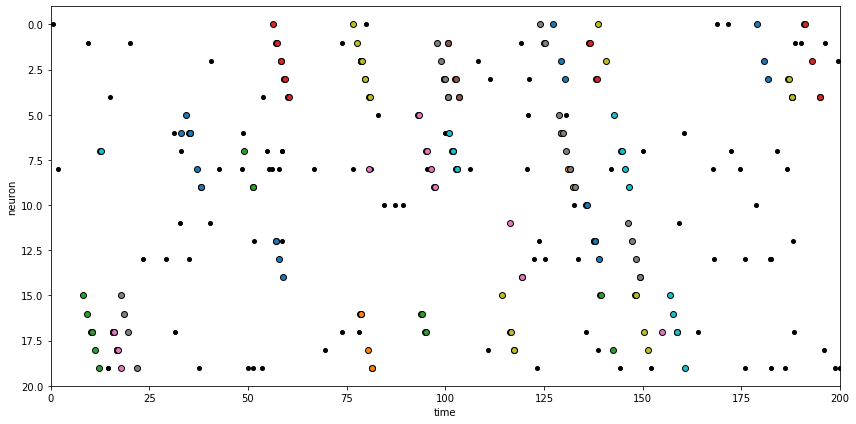

In [11]:
plt.figure(figsize=(12, 6))

for z in np.unique(parents):
        plt.plot(times[parents==z], nodes[parents==z], 
                 'o' if z >= 0 else 'ko',
                 markersize=6 if z>= 0 else 4,
                 markeredgecolor='k')

plt.xlim(0, 200)
plt.ylim(N, -1)
plt.xlabel("time")
plt.ylabel("neuron")
plt.tight_layout()

# Fit the correct model to the data

In [12]:
correct_model = NeymanScottModel(
    mu, alpha, beta, lmbda0, 
    bkgd_class(**bkgd_hypers), 
    SeqNMFClusterFactory(**test_clus_factory_hypers),
)

# Fit the model
# samples = correct_model.fit(data, method="mcem", step_size=0.75, num_iters=50, verbose=True)
samples = correct_model.fit(data, method="gibbs", num_samples=300, init_method="prior")
# samples = correct_model.fit(data, method="gibbs", num_samples=100, init_method="given", z0=parents)
# samples = correct_model.gibbs_sample_posterior(data, num_samples=100, init_method="given", z0=parents)
# samples = correct_model.gibbs_sample_posterior(data, num_samples=100, init_method="background")

# Extract the number of clusters for each sample
t_samples = np.array([s["num_clusters"] for s in samples])

# Permute the sampled parents to match the true ones
inferred_parents = [permute_to_match(parents, s["parents"]) for s in samples]

precomputing log_Vs


num clusters:  62


/Users/scott/Projects/latent_hawkes/src/neyman_scott/clusters.py:861: RuntimeWarning: invalid value encountered in true_divide
  spk_delta_mean = spk_delta_sum / spk_count


num clusters:  49
num clusters:  46
num clusters:  45
num clusters:  49
num clusters:  57
num clusters:  54
num clusters:  51
num clusters:  55
num clusters:  58
num clusters:  60
num clusters:  69
num clusters:  73
num clusters:  75
num clusters:  74
num clusters:  78
num clusters:  77
num clusters:  82
num clusters:  79
num clusters:  82
num clusters:  81
num clusters:  81
num clusters:  82
num clusters:  80
num clusters:  80
num clusters:  82
num clusters:  86
num clusters:  87
num clusters:  87
num clusters:  81
num clusters:  85
num clusters:  80
num clusters:  80
num clusters:  82
num clusters:  83
num clusters:  83
num clusters:  83
num clusters:  86
num clusters:  84
num clusters:  86
num clusters:  89
num clusters:  89
num clusters:  89
num clusters:  93
num clusters:  99
num clusters:  95
num clusters:  93
num clusters:  92
num clusters:  88
num clusters:  90
num clusters:  93
num clusters:  93
num clusters:  94
num clusters:  96
num clusters:  92
num clusters:  93
num cluste

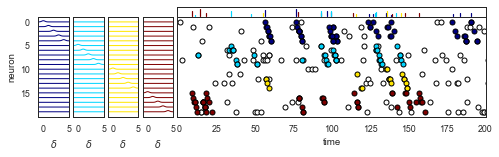

In [17]:
import seaborn as sns
sns.set_context("paper")
sns.set_style("white")

from matplotlib.gridspec import GridSpec
from matplotlib.cm import jet
plt.figure(figsize=(6.75, 2.))
gs = GridSpec(2, M+1, width_ratios=np.concatenate((np.ones(M), [202 / (5*M)])), 
              height_ratios=[1, 10])

cluster_prms = [cluster.sample_posterior() for cluster in clusters]
cluster_types, cluster_times = list(zip(*cluster_prms))
colors = [jet(m / (M-1)) for m in range(M)]

ax_data = plt.subplot(gs[1,M])
# for z in np.unique(inferred_parents[-1]):
#     plt.plot(times[inferred_parents[-1]==z], nodes[inferred_parents[-1]==z], 'o',
for z in np.unique(parents):
    plt.plot(times[parents==z], nodes[parents==z], 'o',
#              'o' if z >= 0 else 'wo',
             markerfacecolor='w' if z == -1 else colors[cluster_types[z]],
             markeredgecolor='k',
             markersize=5)

plt.xlim(-1, 201)
plt.yticks([])
plt.ylim(N, -1)
plt.xlabel("time")
# plt.ylabel("neuron")

from scipy.stats import norm
dt = np.linspace(-1, 5)
# for n in range(N):
#     plt.plot(dt, n * np.ones_like(dt), '-k', lw=1)
for m in range(M):
    plt.subplot(gs[1, m])
    for n in range(N):
#         if pis[m, n] < 1e-3:
#             continue
        plt.plot(dt, n - pis[m, n] * norm.pdf(dt, deltas[m,n], np.sqrt(sigmasqs[m,n])), 
                 '-', color=colors[m], lw=1)
    plt.xlim(-1, 5)
    plt.xlabel("$\\delta$")
    plt.yticks([])
    plt.ylim(N, -1)
    if m == 0:
        plt.yticks(np.arange(N, step=5))
        plt.ylim(N, -1)
        plt.ylabel("neuron")

ax_latents = plt.subplot(gs[0, M])
for k, (z, s) in enumerate(zip(cluster_types, cluster_times)):
    plt.plot([s, s], [0, clusters[k].size], '-', color=colors[z])
plt.xlim(-1, 201)
plt.yticks([])
plt.xticks([])
# plt.ylabel("$A$")
# print(dir(ax_latents.yaxis))

plt.tight_layout(pad=0.05)

plt.savefig("seqnmf.pdf")


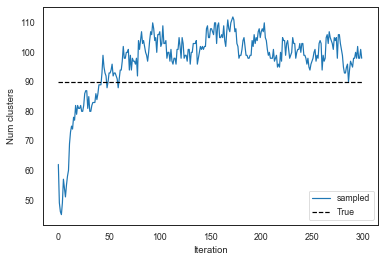

In [14]:
# Plot the number of clusters over samples
plt.figure()
plt.plot([s["num_clusters"] for s in samples], label="sampled")
plt.plot([0, len(samples)], [len(clusters), len(clusters)], '--k', label="True")
plt.xlabel("Iteration")
plt.ylabel("Num clusters")
plt.legend(loc="lower right")
plt.show()

Text(0, 0.5, 'inferred parent')

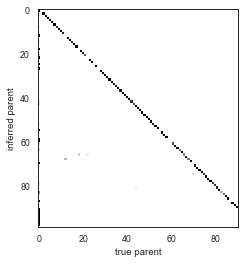

In [15]:
ovlp, rows, cols = compute_state_overlap(parents, inferred_parents[-1])
norm_ovlp = ovlp / ovlp.sum(axis=0, keepdims=True)
plt.imshow(norm_ovlp.T, aspect="equal", cmap="Greys")
plt.xlabel("true parent")
plt.ylabel("inferred parent")

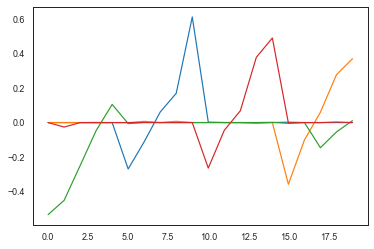

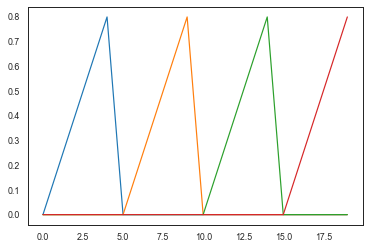

In [16]:
# Plot the cluster parameters
plt.plot((correct_model.cluster_factory.deltas * correct_model.cluster_factory.pis).T)
plt.figure()
plt.plot((deltas * pis).T)